In [1]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [4]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Testing"
image_size = (299,299)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [7]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [8]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomInceptionV3, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        self.inception.aux_logits = False
        
        for param in self.inception.parameters():
            param.requires_grad = False
        
        for param in list(self.inception.parameters())[-2:]:
            param.requires_grad = True
        
        self.custom_conv1 = nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1)
        self.custom_bn1 = nn.BatchNorm2d(256)
        self.custom_conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.custom_bn2 = nn.BatchNorm2d(128)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(128 * 1 * 1, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )
        
    def forward(self, x):
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.maxpool1(x)
        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)
        x = self.inception.maxpool2(x)
        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)
        x = self.inception.Mixed_6a(x)
        x = self.inception.Mixed_6b(x)
        x = self.inception.Mixed_6c(x)
        x = self.inception.Mixed_6d(x)
        x = self.inception.Mixed_6e(x)
        x = self.inception.Mixed_7a(x)
        x = self.inception.Mixed_7b(x)
        x = self.inception.Mixed_7c(x)
        
        x = self.custom_conv1(x)
        x = self.custom_bn1(x)
        x = torch.relu(x)
        x = self.custom_conv2(x)
        x = self.custom_bn2(x)
        x = torch.relu(x)
        
        x = self.global_avg_pool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
num_classes = 4
model = CustomInceptionV3(num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [11]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   Batch 150/179, Loss: 0.5252, Accuracy: 83.80%
Train Loss: 0.4937, Train Accuracy: 84.58%
Eval Loss: 0.3988, Eval Accuracy: 84.73%
Epoch 1,   Batch 150/179, Loss: 0.3005, Accuracy: 89.47%
Train Loss: 0.2990, Train Accuracy: 89.74%
Eval Loss: 0.3220, Eval Accuracy: 88.40%
Epoch 2,   Batch 150/179, Loss: 0.2638, Accuracy: 90.48%
Train Loss: 0.2634, Train Accuracy: 90.27%
Eval Loss: 0.2911, Eval Accuracy: 90.69%
Epoch 3,   Batch 150/179, Loss: 0.2155, Accuracy: 91.95%
Train Loss: 0.2177, Train Accuracy: 91.86%
Eval Loss: 0.2697, Eval Accuracy: 90.08%
Epoch 4,   Batch 150/179, Loss: 0.2191, Accuracy: 91.76%
Train Loss: 0.2175, Train Accuracy: 91.89%
Eval Loss: 0.3171, Eval Accuracy: 89.31%
Epoch 5,   Batch 150/179, Loss: 0.1829, Accuracy: 93.32%
Train Loss: 0.1853, Train Accuracy: 93.15%
Eval Loss: 0.2401, Eval Accuracy: 90.84%
Epoch 6,   Batch 150/179, Loss: 0.1773, Accuracy: 93.46%
Train Loss: 0.1814, Train Accuracy: 93.31%
Eval Loss: 0.1984, Eval Accuracy: 92.98%
Epoch 7,   Ba

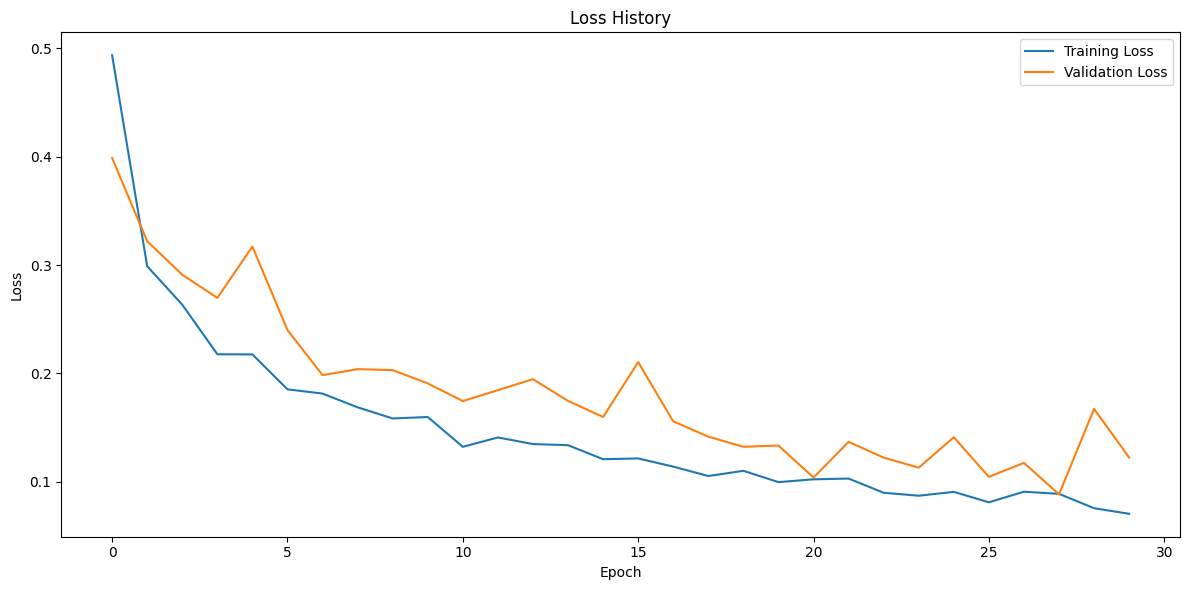

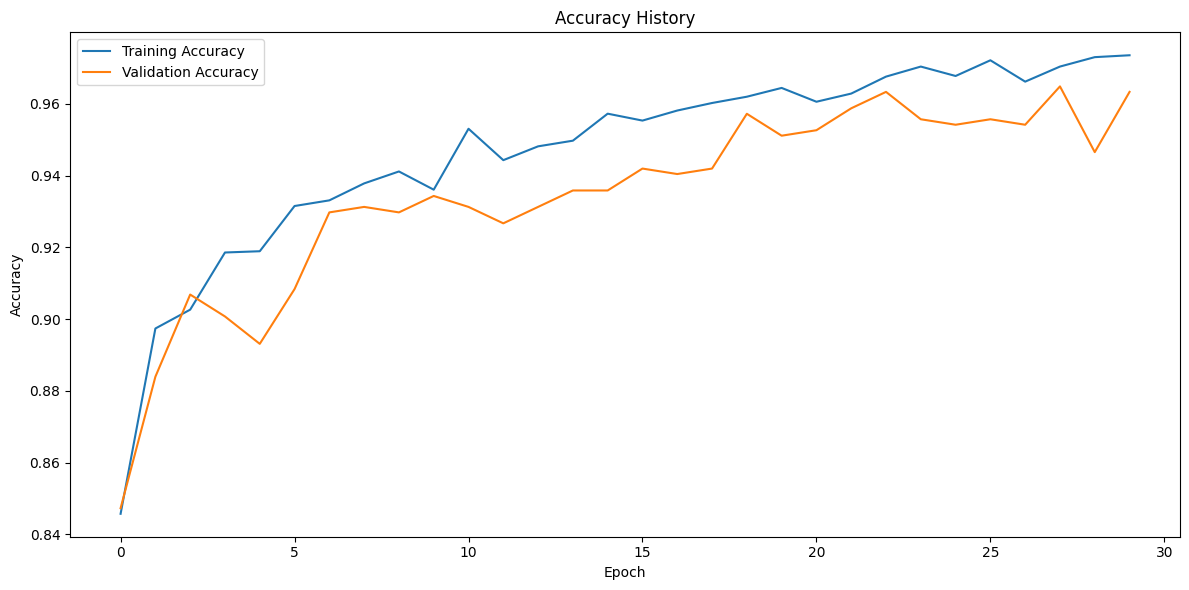

In [16]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [19]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/reseach/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_" +str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_28'

In [20]:
from torchvision import models
inception = models.inception_v3(pretrained=True)
best_model =CustomInceptionV3(num_classes=4).to(device)
pretrained_dict = torch.load(best_model_path, map_location=device)
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
best_model.load_state_dict(model_dict)
print(best_model)


CustomInceptionV3(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3

In [21]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [22]:

best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

656

In [23]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)


656

In [24]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 96.34%


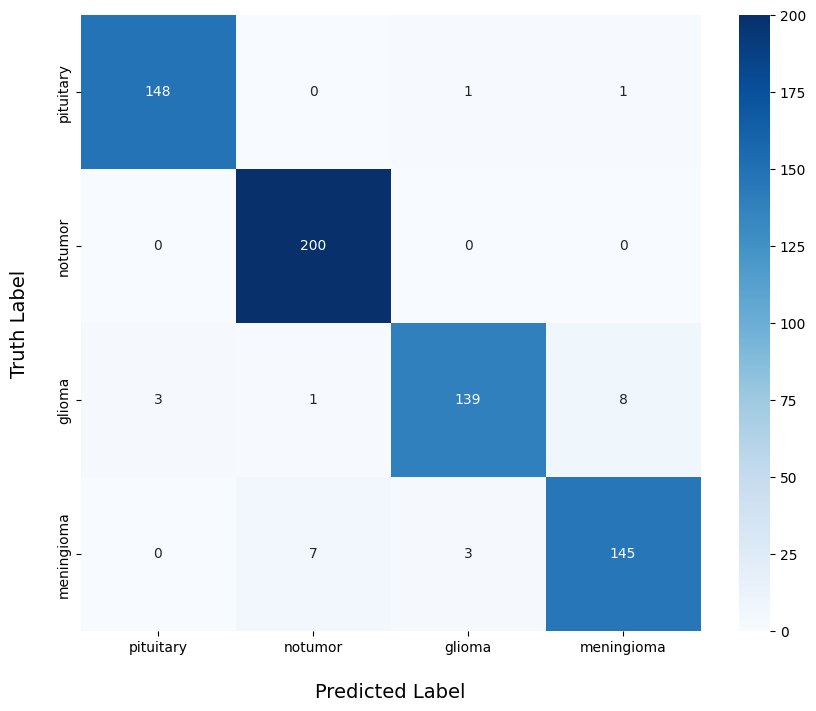

Precision: 0.9634837531633283
Recall: 0.9634146341463414
F1 Score: 0.9631681487941921


In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
precision = precision_score(gen_labels_test_set, best_model_preds, average='weighted')
recall = recall_score(gen_labels_test_set, best_model_preds, average='weighted')
f1 = f1_score(gen_labels_test_set, best_model_preds, average='weighted')
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

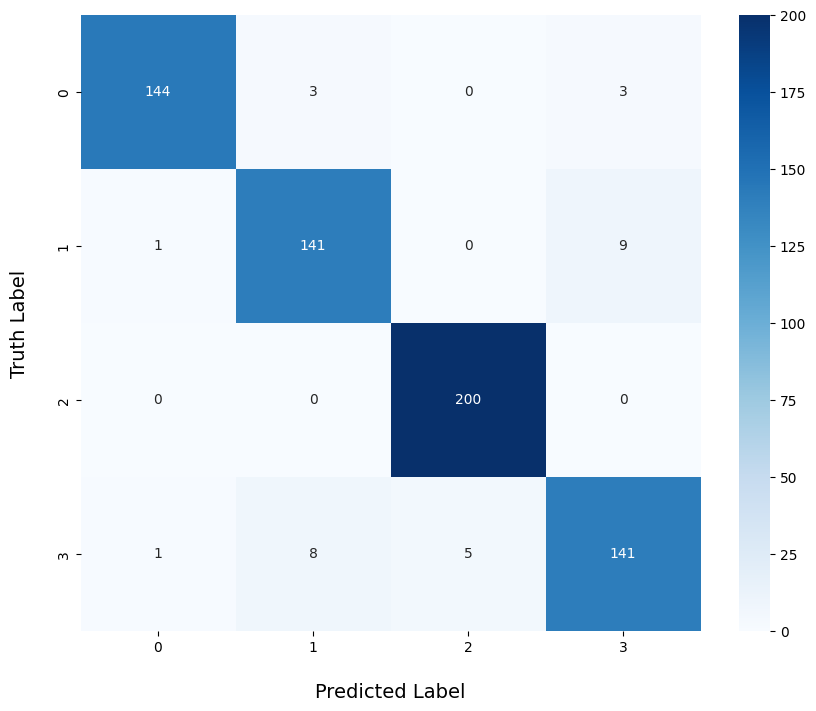

Class: 0
  Precision: 0.9863013698630136
  Recall: 0.96
  F1 Score: 0.972972972972973
Class: 1
  Precision: 0.9276315789473685
  Recall: 0.9337748344370861
  F1 Score: 0.9306930693069307
Class: 2
  Precision: 0.975609756097561
  Recall: 1.0
  F1 Score: 0.9876543209876543
Class: 3
  Precision: 0.9215686274509803
  Recall: 0.9096774193548387
  F1 Score: 0.9155844155844156


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = sorted(set(gen_labels_test_set))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

precision_per_class = precision_score(gen_labels_test_set, best_model_preds, average=None)
recall_per_class = recall_score(gen_labels_test_set, best_model_preds, average=None)
f1_per_class = f1_score(gen_labels_test_set, best_model_preds, average=None)

for i, label in enumerate(labels):
    print(f'Class: {label}')
    print(f'  Precision: {precision_per_class[i]}')
    print(f'  Recall: {recall_per_class[i]}')
    print(f'  F1 Score: {f1_per_class[i]}')
